# DSE 230 - Final Project - Reddit / Stock Conversations Graph

## Import Packages

In [1]:
## only needed to run for first time, leave disabled after that

#import nltk
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('universal_tagset')

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import re
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.models import Phrases
from gensim.corpora import Dictionary

In [3]:
t_ = time()

## Define Functions

In [4]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 5, figsize=(30, 22), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Load Data

In [5]:
df_posts = pd.read_csv('./data/wsb-aug-2021-posts.csv')
df_comments = pd.read_csv('./data/wsb-aug-2021-comments.csv')

## Clean Data

In [6]:
print(df_posts.shape)
df_posts[df_posts['selftext'].isna()]
df_posts.dropna(subset=['selftext'], inplace=True)
print(df_posts.shape)
df_posts = df_posts[(df_posts['selftext'] != '[removed]') & (df_posts['selftext'] != '[deleted]')]
print(df_posts.shape)

(25751, 12)
(17420, 12)
(766, 12)


In [7]:
print(df_comments.shape)
df_comments[df_comments['body'].isna()]
df_comments.dropna(subset=['body'], inplace=True)
print(df_comments.shape)
df_comments = df_comments[(df_comments['body'] != '[removed]') & (df_comments['body'] != '[deleted]')]
print(df_comments.shape)

(1001160, 10)
(1001158, 10)
(813951, 10)


In [8]:
df_posts['created_utc'] = df_posts['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_posts['selftext'] = df_posts['selftext'].apply(lambda s: re.sub(r'http\S+', '',s))
df_posts['selftext'] = df_posts['selftext'].apply(lambda s: re.sub(r'www\S+', '',s))
df_comments['created_utc'] = df_comments['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_comments['body'] = df_comments['body'].str.replace('\\','')
df_comments['body'] = df_comments['body'].apply(lambda s: re.sub(r'http\S+', '',s))
df_comments['body'] = df_comments['body'].apply(lambda s: re.sub(r'www\S+', '',s))
df_comments['postId_commented_on'] = df_comments['permalink'].str.split('/').str[6]

<ipython-input-8-1b37883448a9>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_comments['body'] = df_comments['body'].str.replace('\\','')


In [9]:
df_posts.drop(columns=['subreddit.id','subreddit.nsfw','url'], inplace=True)
df_comments.drop(columns=['subreddit.id','subreddit.nsfw'], inplace=True)

In [10]:
clean_posts = df_posts['id'].unique()
df_connected_comments = df_comments[df_comments['postId_commented_on'].isin(clean_posts)].copy()
df_connected_comments.shape

(615920, 9)

In [11]:
df_posts.reset_index(drop=True, inplace=True)
df_comments.reset_index(drop=True, inplace=True)
df_connected_comments.reset_index(drop=True, inplace=True)

In [12]:
df_comments.head()

,type,id,subreddit.name,created_utc,permalink,body,sentiment,score,postId_commented_on
0,comment,hb4hdm3,wallstreetbets,2021-08-31 16:59:54,https://old.reddit.com/r/wallstreetbets/commen...,What's updog,NaN,3,pfdkjw
1,comment,hb4hdm8,wallstreetbets,2021-08-31 16:59:54,https://old.reddit.com/r/wallstreetbets/commen...,Don’t tell em,NaN,1,pfdkjw
2,comment,hb4hdjc,wallstreetbets,2021-08-31 16:59:53,https://old.reddit.com/r/wallstreetbets/commen...,"I realize this, ive been losing thousands shoo...",0.6369,2,pfdkjw
3,comment,hb4hdgo,wallstreetbets,2021-08-31 16:59:52,https://old.reddit.com/r/wallstreetbets/commen...,then it tanks after earnings,0.0000,4,pfgr1h
4,comment,hb4hdeh,wallstreetbets,2021-08-31 16:59:51,https://old.reddit.com/r/wallstreetbets/commen...,Are you saying I should or shouldn’t yolo my l...,0.2732,1,pf3xee


In [13]:
df_posts.head()

,type,id,subreddit.name,created_utc,permalink,domain,selftext,title,score
0,post,pfhpj2,wallstreetbets,2021-08-31 16:39:53,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,&amp;#x200B;\n\n\n\n\n\n# NFA. POSITIONS: [\n\...,$GENI DD | I'm either a $GENIus or a retard. 2...,73
1,post,pfgew5,wallstreetbets,2021-08-31 15:27:03,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,This started about 4 years ago when my son was...,Am I The Asshole for dropping my 6 year old of...,27876
2,post,pfeq9a,wallstreetbets,2021-08-31 13:58:37,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,\n**Can Workhorse Find the Strength to Bounce ...,$WKHS Is A Sleeping Giant,1
3,post,pfdu9b,wallstreetbets,2021-08-31 13:13:51,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,So I was having a look at the [S-4/A form]( fo...,$RKLB: Insiders are incentivized to get the sh...,101
4,post,pfdkjw,wallstreetbets,2021-08-31 13:00:21,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,Your daily trading discussion thread. Please k...,"What Are Your Moves Tomorrow, September 01, 2021",321


In [14]:
df_comments.to_csv('comments_edited.csv', index=False)

## Yahoo Finance

In [15]:
companies = pd.read_csv('./data/Companies.csv')
comps = companies.iloc[:,0]

In [16]:
comp_prices = pd.DataFrame()
for comp in comps:
    tick = yf.Ticker(comp)
    dat = tick.history(start='2020-01-01', end='2021-12-06')
    dat['Delta'] = dat['Close']-dat['Open']
    dat['Ticker'] = comp
    comp_prices = comp_prices.append(dat)
comp_prices = comp_prices.reset_index(drop=False)
comp_prices[['Ticker','Date','Open','Close','Delta']]

,Ticker,Date,Open,Close,Delta
0,AAPL,2020-01-02,72.976015,73.988480,1.012465
1,AAPL,2020-01-03,73.200182,73.269157,0.068975
2,AAPL,2020-01-06,72.372478,73.852982,1.480503
3,AAPL,2020-01-07,73.862828,73.505638,-0.357190
4,AAPL,2020-01-08,73.202637,74.688072,1.485435
...,...,...,...,...,...
37418,GME,2021-11-29,204.000000,202.009995,-1.990005
37419,GME,2021-11-30,200.100006,196.210007,-3.889999
37420,GME,2021-12-01,199.399994,179.839996,-19.559998
37421,GME,2021-12-02,185.000000,181.559998,-3.440002


In [17]:
comp_prices.to_csv('company_prices.csv')

## Exploratory Data Analysis

## Create Graph

## Latent Dirichlet Allocation

In [18]:
df_posts.head()

,type,id,subreddit.name,created_utc,permalink,domain,selftext,title,score
0,post,pfhpj2,wallstreetbets,2021-08-31 16:39:53,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,&amp;#x200B;\n\n\n\n\n\n# NFA. POSITIONS: [\n\...,$GENI DD | I'm either a $GENIus or a retard. 2...,73
1,post,pfgew5,wallstreetbets,2021-08-31 15:27:03,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,This started about 4 years ago when my son was...,Am I The Asshole for dropping my 6 year old of...,27876
2,post,pfeq9a,wallstreetbets,2021-08-31 13:58:37,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,\n**Can Workhorse Find the Strength to Bounce ...,$WKHS Is A Sleeping Giant,1
3,post,pfdu9b,wallstreetbets,2021-08-31 13:13:51,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,So I was having a look at the [S-4/A form]( fo...,$RKLB: Insiders are incentivized to get the sh...,101
4,post,pfdkjw,wallstreetbets,2021-08-31 13:00:21,https://old.reddit.com/r/wallstreetbets/commen...,self.wallstreetbets,Your daily trading discussion thread. Please k...,"What Are Your Moves Tomorrow, September 01, 2021",321


In [19]:
# Tokenize these documents
data = df_posts.loc[:10,'selftext'].copy()
#data = data.values.tolist()

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(data)):
    data[idx] = data[idx].lower()  # Convert to lowercase.
    data[idx] = tokenizer.tokenize(data[idx])  # Split into words.

# Keep only select parts-of-speech
data = [[token[0] for token in pos_tag(dat, tagset='universal', lang='eng') if token[1] in ['ADJ', 'ADV', 'NOUN', 'VERB']] for dat in data] 

print()
# Remove numbers, but not words that contain numbers.
data = [[token for token in dat if not token.isnumeric()] for dat in data]

# Remove words that are only one character.
data = [[token for token in dat if len(token) > 1] for dat in data]

# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
data = [[lemmatizer.lemmatize(token) for token in dat] for dat in data]

detokenizer = TreebankWordDetokenizer()
data = [detokenizer.detokenize(dat) for dat in data]

print(data[:2])


['amp x200b position geni dd genius retard position not yolo know right geni tldr cathie ark fund nfl season incoming earnings nfl exclusive partner huge moat dkng possible deal espn called repos39 guy called negg more doe geni do act intermediary providing data sport league sportbooks help sportsbook draftkings provide live prop bet will person strike bat end are technology company utilizes official sport data live play play statistic way provides intrinsic value sportsbook partner medium organization sport league etc bet cathie wood arkw geni buy cathie ha been doing overtime buying shit geni aug share bought buy arkw aug share bought buy arkw aug share bought buy arkw aug share bought buy arkw aug share bought buy arkw aug share bought buy arkw aug share bought buy arkw aug share bought buy arkw aug share bought buy arkw nfl season start september stock dkng geni etc are know run event pair wa upcoming earnings report geni could see crazy run start nfl season earnings report quarte

In [20]:
df_posts.loc[:2,'selftext'].values.tolist()

['&amp;#x200B;\n\n\n\n\n\n# NFA. POSITIONS: [\n\n# $GENI DD | I\'m either a $GENIus or a retard. 260K position. Not a YOLO, because I know I\'m right.\n\n\n\n# $GENI TLDR: Cathie ARK Funds, NFL season incoming, 9/8 earnings, NFL exclusive partner, huge MOAT, DKNG possible deal with ESPN, called by Repos39 (guy who called NEGG) and more.\n\n# What Does $GENI Do?\n\nThey act as an intermediary for providing data from Sports Leagues to Sportbooks. This helps sportsbook like Draftkings provide live prop bets like "Will the Person Strike Out in this At Bat?" In the end, they are a technology company that utilizes official sports data (Live Play by Play Statistics) in a way that provides intrinsic value to Sportsbook partners, media organizations, sports leagues, etc.\n\n# Bet on Cathie Wood : ARKW $GENI Buys\n\nCathie has been doing overtime and buying the shit out of $GENI.\n\n\\- AUG 05 2021\xa0 280,214 SHARES BOUGHT BUY ARKW\n\n\\- AUG 06 2021\xa0 69,930 SHARES BOUGHT BUY ARKW\n\n\\- AUG

In [21]:
print("Loading dataset...")
t0 = time()
data = df_comments['body'].values.tolist()[:10]
data_samples = data # data[:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
   max_features=1000, stop_words="english", ngram_range=(1,2)
)
t0 = time()
tf = tf_vectorizer.fit_transform(data)
print("done in %0.3fs." % (time() - t0))
print(tf)

Loading dataset...
done in 0.024s.
Extracting tf features for LDA...
done in 0.214s.
  (0, 109)	1
  (1, 26)	1
  (1, 97)	1
  (1, 29)	1
  (1, 27)	1
  (1, 98)	1
  (2, 70)	1
  (2, 50)	1
  (2, 56)	1
  (2, 99)	1
  (2, 85)	1
  (2, 91)	1
  (2, 52)	2
  (2, 18)	2
  (2, 61)	1
  (2, 103)	1
  (2, 89)	1
  (2, 67)	1
  (2, 13)	1
  (2, 24)	1
  (2, 40)	1
  (2, 48)	1
  (2, 4)	1
  (2, 71)	1
  (2, 51)	1
  :	:
  (7, 21)	1
  (7, 112)	1
  (7, 33)	1
  (7, 75)	1
  (7, 3)	1
  (8, 38)	1
  (8, 5)	1
  (8, 101)	1
  (8, 15)	1
  (8, 39)	1
  (8, 6)	1
  (8, 102)	1
  (9, 44)	1
  (9, 9)	1
  (9, 46)	1
  (9, 65)	1
  (9, 93)	1
  (9, 22)	1
  (9, 60)	1
  (9, 45)	1
  (9, 10)	1
  (9, 47)	1
  (9, 66)	1
  (9, 94)	1
  (9, 23)	1


Loading dataset...
done in 461.114s.
Extracting tf features for LDA...
done in 18.401s.


 Fitting LDA models with tf features, n_samples=813951 and n_features=1000...
done in 266.045s.


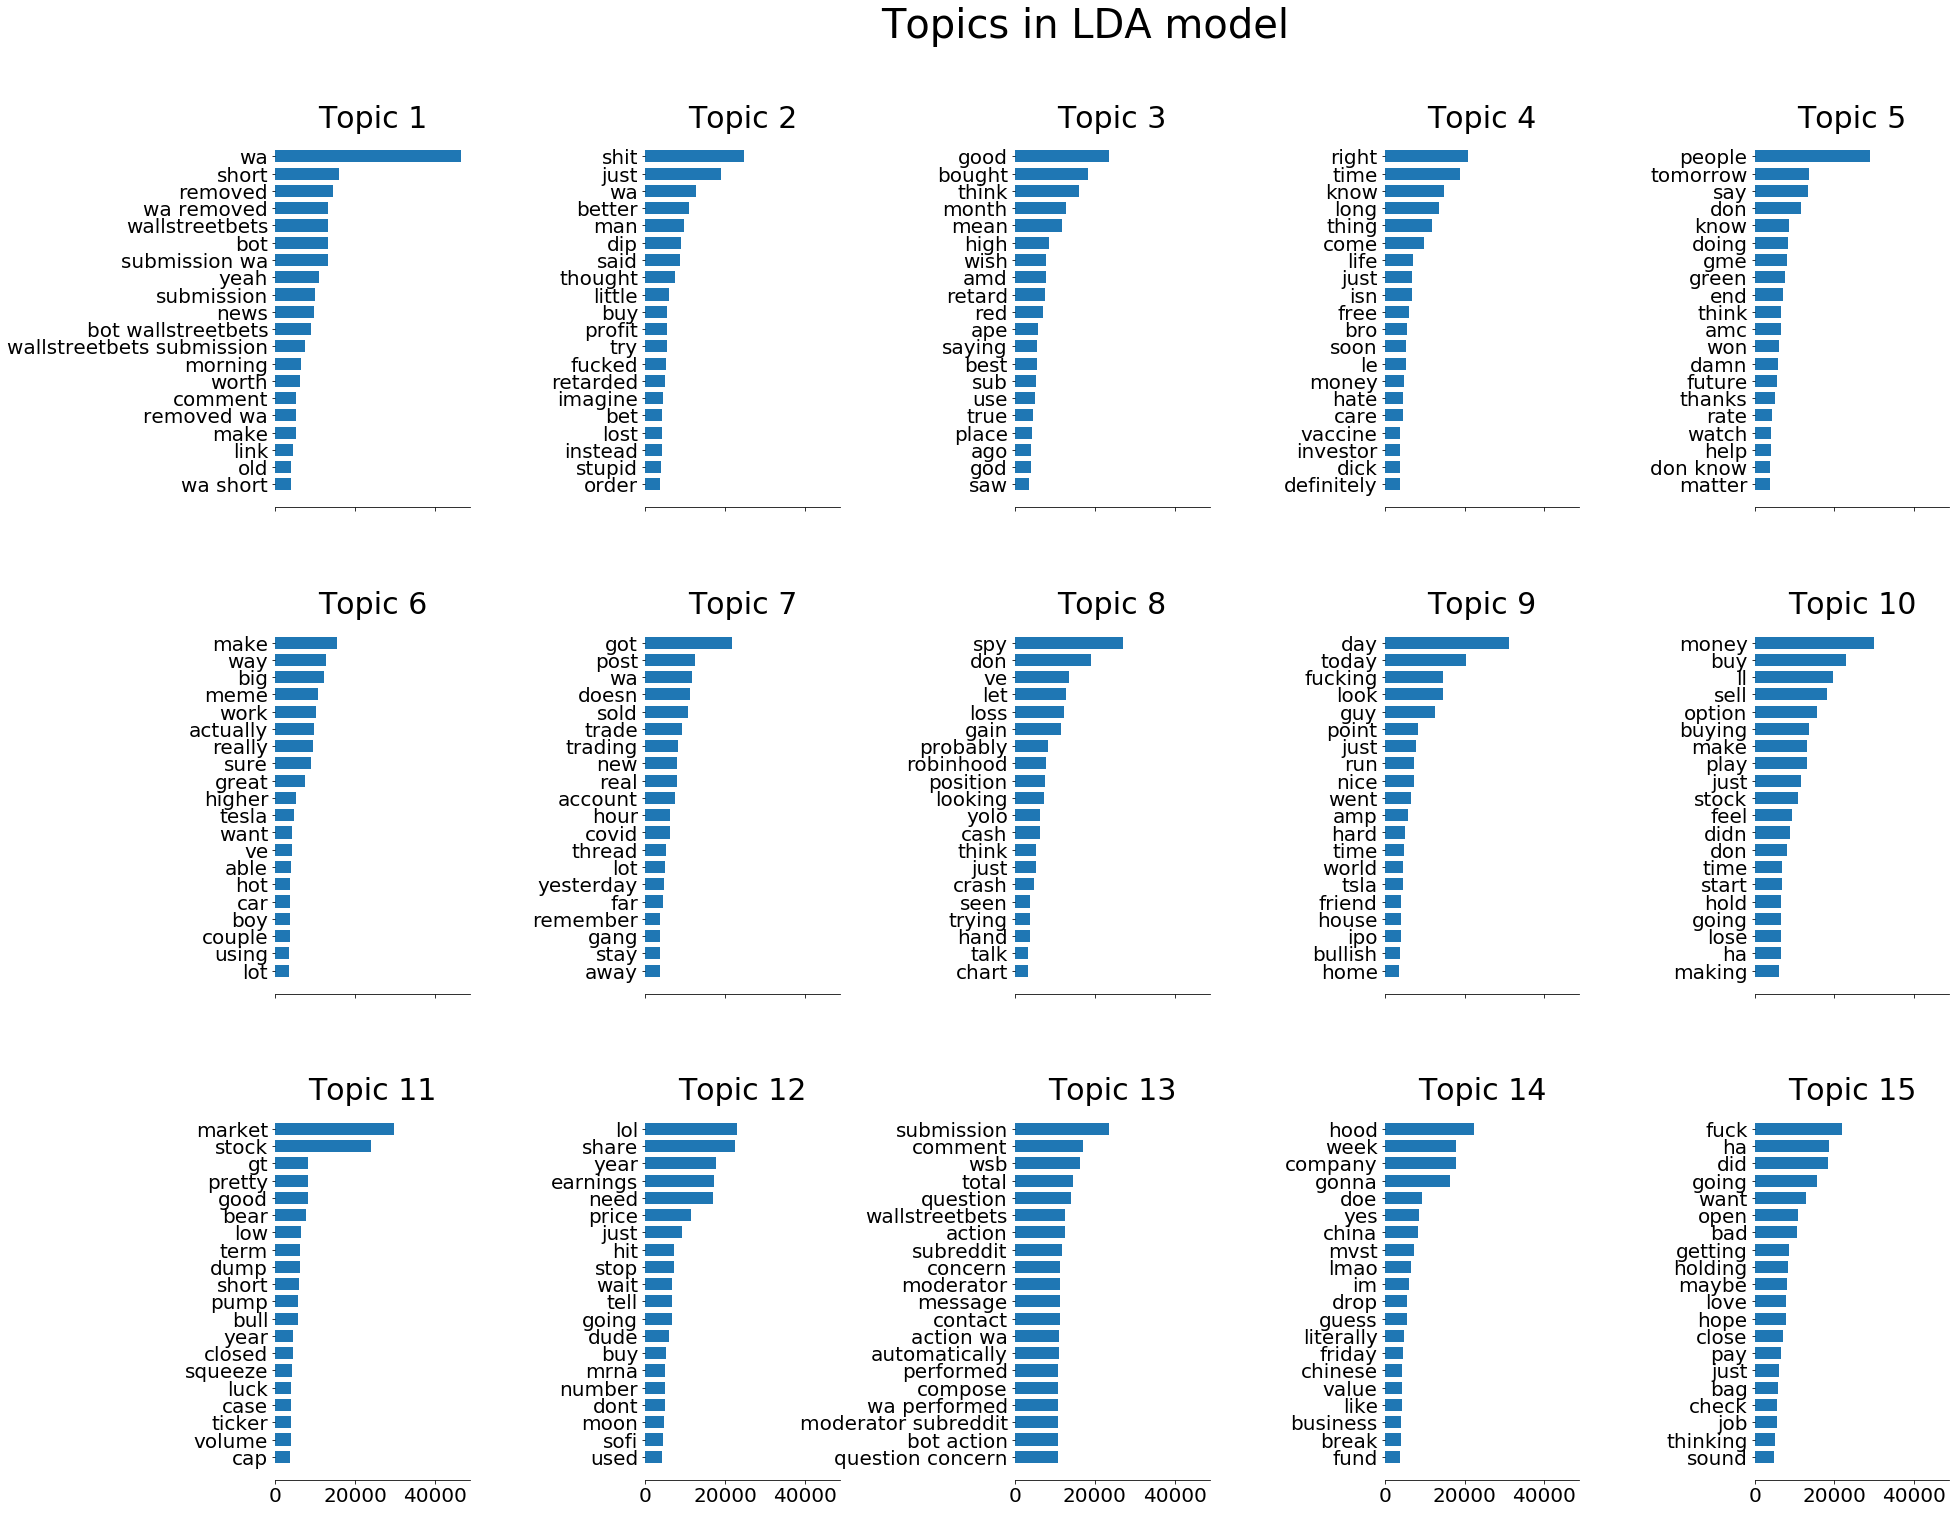

In [22]:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

n_samples = len(df_comments['body'])
n_features = 1000
n_components = 15
n_top_words = 20
ngram_range = (1, 2)


print("Loading dataset...")
t0 = time()
data = df_comments['body'].copy()#.values.tolist()
data = data[:n_samples].copy()

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(data)):
    data[idx] = data[idx].lower()  # Convert to lowercase.
    data[idx] = tokenizer.tokenize(data[idx])  # Split into words.

# Keep only select parts-of-speech
data = [[token[0] for token in pos_tag(dat, tagset='universal', lang='eng') if token[1] in ['ADJ', 'ADV', 'NOUN', 'VERB']] for dat in data] 

# Remove numbers, but not words that contain numbers.
data = [[token for token in dat if not token.isnumeric()] for dat in data]

# Remove words that are only one character.
data = [[token for token in dat if len(token) > 1] for dat in data]

# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
data = [[lemmatizer.lemmatize(token) for token in dat] for dat in data]

# Returning to a list of strings (i.e. Detokenizing) to format for CountVectorizer()
detokenizer = TreebankWordDetokenizer()
data = [detokenizer.detokenize(dat) for dat in data]
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
# The posts are stripped of common English words, words occurring in only one document 
# or in at least 95% of the documents are removed.
# n-grams are also formed for inclusion in the analysis
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english", ngram_range=ngram_range
)
t0 = time()
tf = tf_vectorizer.fit_transform(data)
print("done in %0.3fs." % (time() - t0))


print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### LDA Topics

##### 1. Administrative Removal of Content
##### 2. Missed Opportunity
##### 3. Positivity
##### 4. Timing
##### 5. Gamestop & AMC
##### 6. Tesla
##### 7. Past Occurrences
##### 8. SPY ticker (SPDR S&P 500 Trust ETF)
##### 9. Today's Occurrences
##### 10. Transactions
##### 11. General Market Behavior
##### 12. Stock Ownership
##### 13. Subreddit Adminstrative Concerns
##### 14. Robinhood
##### 15. Mixed Banter

In [23]:
topic_map = dict({
    0:'Administrative Removal of Content',
    1:'Missed Opportunity',
    2:'Positivity',
    3:'Timing',
    4:'Gamestop & AMC',
    5:'Tesla',
    6:'Past Occurrences',
    7:'SPY ticker',
    8:'Todays Occurrences',
    9:'Transactions',
    10:'General Market Behavior',
    11:'Stock Ownership',
    12:'Subreddit Adminstrative Concerns',
    13:'Robinhood',
    14:'Mixed Banter',
})

In [26]:
# cleaned comments
t0 = time()
x=tf_vectorizer.transform(df_comments.loc[:,'body'].values.tolist())
y=lda.transform(x)
print("done in %0.3fs." % (time() - t0))

df_comments['topic'] = np.argmax(y, axis=1)
df_comments['topic_label'] = df_comments['topic'].map(topic_map)
df_comments['score'] = np.max(y, axis=1)

t=df_comments['topic'].value_counts(sort=False)
t/t.sum()*100

done in 36.139s.


0     14.960851
1      6.792915
2      5.931684
3      5.483008
4      6.613543
5      3.787083
6      5.312113
7      5.854775
8      6.882847
9      8.630618
10     5.394674
11     7.046002
12     2.887152
13     7.880081
14     6.542654
Name: topic, dtype: float64

In [27]:
# comments with connected post
t0 = time()
x2=tf_vectorizer.transform(df_connected_comments.loc[:,'body'].values.tolist())
y2=lda.transform(x2)
print("done in %0.3fs." % (time() - t0))

df_connected_comments['topic'] = np.argmax(y2, axis=1)
df_connected_comments['topic_label'] = df_connected_comments['topic'].map(topic_map)
df_connected_comments['score'] = np.max(y2, axis=1)

t2=df_connected_comments['topic'].value_counts(sort=False)
t2/t2.sum()*100

done in 25.556s.


0     14.620081
1      7.001234
2      5.990713
3      5.610144
4      6.969736
5      3.678400
6      5.414827
7      6.055170
8      7.408754
9      8.429017
10     5.482205
11     7.225938
12     1.172393
13     8.392973
14     6.548415
Name: topic, dtype: float64

In [28]:
# cleaned posts
t0 = time()
x3=tf_vectorizer.transform(df_posts.loc[:,'selftext'].values.tolist())
y3=lda.transform(x3)
print("done in %0.3fs." % (time() - t0))

df_posts['topic'] = np.argmax(y3, axis=1)
df_posts['topic_label'] = df_posts['topic'].map(topic_map)
df_posts['score'] = np.max(y3, axis=1)

t3=df_posts['topic'].value_counts(sort=False)
t3/t3.sum()*100

done in 0.308s.


0      0.783290
1      1.305483
2      3.002611
3      3.785901
4     11.618799
5      4.046997
6      5.744125
7      1.958225
8     15.274151
9     12.663185
10    17.885117
11    10.704961
12     0.261097
13     9.530026
14     1.436031
Name: topic, dtype: float64

In [29]:
y[5]

array([0.00833333, 0.00833333, 0.00833333, 0.25833333, 0.00833333,
       0.00833335, 0.38333333, 0.00833333, 0.00833333, 0.00833333,
       0.00833333, 0.00833333, 0.00833333, 0.00833333, 0.25833332])

In [30]:
np.argmax(y[5])+1

7

In [31]:
df_comments.loc[5,'body']

'Right?! You’re here because you trade and trading means getting your heart broken on a semi regular basis and getting over it right quick.'

In [32]:
df_posts.shape

(766, 11)

In [33]:
df_posts.to_csv('df_posts.csv')
#df_comments.to_csv('df_comments.csv')
#df_connected_comments.to_csv('df_connected_comments.csv')
cutpoint = int(len(df_comments)/3)
df_comments.iloc[:cutpoint,:].to_csv('df_comments_with_topic_1of3.csv')
df_comments.iloc[cutpoint:cutpoint*2,:].to_csv('df_comments_with_topic_2of3.csv')
df_comments.iloc[cutpoint*2:,:].to_csv('df_comments_with_topic_3or3.csv')  

In [34]:
print("workbook done in %0.3fs." % (time() - t_))

workbook done in 6701.346s.
